In [4]:
!pip install gensim fasttext scikit-learn nltk

import pandas as pd
import numpy as np
import nltk
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from gensim.models import Word2Vec, FastText

nltk.download('punkt')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 73.4/73.4 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Using cached pybind11-3.0.2-py3-none-any.whl.metadata (10 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 61.2 MB/s eta 0:00:00
Using cached pybind11-3.0.2-py3-none-any.whl (310 kB)
  Created wheel for fasttext: filename=fasttext-0.9.3-cp312-cp312-linux_x86_64.whl size=4647422 sha256=a3112e768c091280751f1030538537d45267801e162b0bf6fba0b5ef4ea5142c
  Stored in directory: /root/.cache/pip/wheels/20/27/95/a7baf1b435f1cbde017cabdf1e9688526d2b0e929255a359c6
Successfully built fasttext


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [5]:
import pandas as pd

#load data
df = pd.read_csv("data.tsv", sep="\t", header=None)
#Name the columns for clarity
df.columns = ["id_en", "en", "id_fr", "fr"]
df.head()

,id_en,en,id_fr,fr
0,1276,Let's try something.,3091,Essayons quelque chose !
1,1276,Let's try something.,456963,Tentons quelque chose !
2,1277,I have to go to sleep.,373908,Je dois aller dormir.
3,1280,Today is June 18th and it is Muiriel's birthday!,3095,Aujourd'hui nous sommes le 18 juin et c'est l'...
4,1280,Today is June 18th and it is Muiriel's birthday!,696081,"Aujourd'hui c'est le 18 juin, et c'est l'anniv..."


In [6]:
len(df)

429372

In [7]:
# Import regular expressions library for text cleaning
import re

def clean_text(text):
    text = text.lower() # Convert text to lowercase
    text = re.sub(r"\d+", "", text)  # remove digits
    text = re.sub(r"[^\w\s]", "", text) # Remove punctuation
    return text

# Apply text cleaning to both English and French columns
df["en_clean"] = df["en"].map(clean_text)
df["fr_clean"] = df["fr"].map(clean_text)

In [8]:
# Tokenize the cleaned text into words
df["en_tokens"] = df["en_clean"].str.split()
df["fr_tokens"] = df["fr_clean"].str.split()


# Convert tokenized sentences into lists for embedding training
sentences_en = df["en_tokens"].tolist()
sentences_fr = df["fr_tokens"].tolist()

In [9]:
sentences_en[:10]

[['lets', 'try', 'something'],
 ['lets', 'try', 'something'],
 ['i', 'have', 'to', 'go', 'to', 'sleep'],
 ['today', 'is', 'june', 'th', 'and', 'it', 'is', 'muiriels', 'birthday'],
 ['today', 'is', 'june', 'th', 'and', 'it', 'is', 'muiriels', 'birthday'],
 ['muiriel', 'is', 'now'],
 ['the', 'password', 'is', 'muiriel'],
 ['i', 'will', 'be', 'back', 'soon'],
 ['i', 'will', 'be', 'back', 'soon'],
 ['i', 'will', 'be', 'back', 'soon']]

**One Hot Encoding**

In [10]:
from sklearn.feature_extraction.text import CountVectorizer
# Create a CountVectorizer for one-hot encoding
vectorizer = CountVectorizer(
    max_features=5000,   # vocabulary size
    binary=True          # makes it 0/1 instead of counts
)

# Fit the vectorizer on English cleaned sentences and transform to vectors
X = vectorizer.fit_transform(df["en_clean"])

In [11]:
X.shape

(429372, 5000)

In [12]:
# Get the vocabulary learned by the vectorizer
vocab = vectorizer.get_feature_names_out()
# Print first 20 words of the vocabulary
print(vocab[:20])

['abandon' 'abandoned' 'ability' 'able' 'aboard' 'about' 'above' 'abroad'
 'absence' 'absent' 'absolute' 'absolutely' 'absorbed' 'abstract' 'absurd'
 'abuse' 'abusing' 'accent' 'accept' 'acceptable']


In [13]:
# Print one-hot vector of first sentence
print(X[0])

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 3 stored elements and shape (1, 5000)>
  Coords	Values
  (0, 2506)	1
  (0, 4607)	1
  (0, 4039)	1


(0, 2506) 1
Means:
Row 0
Column 2506
Value = 1
So the word at vocabulary index 2506 appears in the sentence.

In [14]:
# Access a specific word in the vocabulary (example)
vocab = vectorizer.get_feature_names_out()
print(vocab[2506])

lets



**TF-IDF vectorization**

In [15]:
# TF-IDF for English
vectorizer_en = TfidfVectorizer(max_features=10000)
X_en_tfidf = vectorizer_en.fit_transform(df["en_clean"])
# TF-IDF for French
vectorizer_fr = TfidfVectorizer(max_features=10000)
X_fr_tfidf = vectorizer_fr.fit_transform(df["fr_clean"])

# Example: show features
print("EN TF-IDF features:", vectorizer_en.get_feature_names_out()[:10])
print("FR TF-IDF features:", vectorizer_fr.get_feature_names_out()[:10])

EN TF-IDF features: ['aah' 'abacus' 'abandon' 'abandoned' 'abated' 'abducted' 'abhor' 'abide'
 'abilities' 'ability']
FR TF-IDF features: ['abandonna' 'abandonne' 'abandonner' 'abandonné' 'abandonnée' 'abasourdi'
 'abattu' 'abattus' 'abeille' 'abeilles']


**Word2Vec**

In [16]:
# Word2Vec for English
w2v_en = Word2Vec(sentences_en, vector_size=100, window=5, min_count=5, workers=4)
# Word2Vec for French
w2v_fr = Word2Vec(sentences_fr, vector_size=100, window=5, min_count=5, workers=4)

# Example
print("EN Word2Vec 'go':", w2v_en.wv["go"])
print("FR Word2Vec 'aller':", w2v_fr.wv["aller"])

EN Word2Vec 'go': [-0.6018251  -1.0265191  -1.390765    1.9967483  -3.050863   -1.2184485
 -2.6367002   2.0018325  -0.6644314   0.9317768  -1.589141    1.4757332
 -2.123236    2.831934    0.5428267  -0.08735596 -0.8311093  -1.4108826
 -0.2038459   1.4478742   0.0271831   1.5483472  -0.8658167   1.0928258
 -0.43610808  0.16900201 -0.4853684   0.1486537  -2.2591858   0.6069108
 -0.546062    1.9328204  -2.372616    0.3707813  -1.0890732   0.14674841
 -0.38202235 -0.8641312  -1.3821914  -0.3892517  -2.72267     0.4127762
  1.7231343  -0.7025973   0.19203125  2.1479716  -2.3638546   0.35461223
 -1.7222126   0.99422276  2.3536034   0.9364781   0.6410708   0.822736
  0.6094758  -1.9762865  -0.5614368  -2.5789125  -2.4893973   3.1807075
  0.63178754  0.328221    1.139168   -1.05588    -0.7154259  -1.7492996
  0.60539865  1.3854439   0.7353652  -0.15740186 -1.0151663   0.06750798
  0.71161264 -3.7800977  -2.0339966   1.6144966   3.0309272  -0.15213673
  2.1856833  -1.6457638   2.1884794  -0.085

**GloVe**

In [17]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip glove.6B.zip

--2026-02-17 16:23:34--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2026-02-17 16:23:34--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2026-02-17 16:23:35--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glov

In [18]:
def load_glove(path):
    model = {}
    with open(path, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            vector = np.array(values[1:], dtype=float)
            model[word] = vector
    return model

glove_en = load_glove("glove.6B.100d.txt")
# Example
print("GloVe EN 'go':", glove_en.get("go"))

GloVe EN 'go': [-0.078894  0.4616    0.57779  -0.71637  -0.13121   0.4186   -0.29156
  0.52006   0.089986 -0.35062   0.51755   0.51998   0.15218   0.41485
 -0.12377  -0.37222   0.0273    0.75673  -0.8739    0.58935   0.46662
  0.62918   0.092603 -0.012868 -0.015169  0.25567  -0.43025  -0.77668
  0.71449  -0.3834   -0.69638   0.23522   0.11396   0.02778   0.071357
  0.87409  -0.1281    0.063576  0.067867 -0.50181  -0.28523  -0.072536
 -0.50738  -0.6914   -0.53579  -0.11361  -0.38234  -0.12414   0.011214
 -1.1622    0.037057 -0.18495   0.01416   0.87193  -0.097309 -2.3565
 -0.14554   0.28275   2.0053    0.23439  -0.38298   0.69539  -0.44916
 -0.094157  0.90527   0.65764   0.27628   0.30688  -0.57781  -0.22987
 -0.083043 -0.57236  -0.299    -0.81112   0.039752 -0.05681  -0.48879
 -0.18091  -0.28152  -0.20559   0.4932   -0.033999 -0.53139  -0.28297
 -1.4475   -0.18685   0.091177  0.11454  -0.28168  -0.33565  -0.31663
 -0.1089    0.10111  -0.23737  -0.64955  -0.268     0.35096   0.26352
  0

**FastText**

In [19]:
# Train FastText
ft_en = FastText(sentences_en, vector_size=100, window=5, min_count=5, workers=4)
ft_fr = FastText(sentences_fr, vector_size=100, window=5, min_count=5, workers=4)

# Example
print("FastText EN 'hello':", ft_en.wv["hello"])
print("FastText FR 'bonjour':", ft_fr.wv["bonjour"])

# FastText handles OOV words
print("FastText EN OOV 'helloooo':", ft_en.wv["helloooo"])

FastText EN 'hello': [ 0.16667572 -0.26180086  0.39829436  0.05670277 -0.4651331  -0.2719873
  0.5897834  -0.37914327 -1.0732749  -0.6189989   0.05779842  0.37476462
  0.78885144 -0.5533919  -0.12110063 -0.33800152 -0.00271836  0.38831395
 -0.11203034 -0.49634096  0.58042353 -0.29778913  0.54704416 -0.02236755
  0.02239947 -0.72886044 -0.26444185  0.01598519 -0.321195    0.7774553
  0.54823023  0.0522145  -0.04288818  0.47554958  0.3950181   0.5248521
  0.10219324  0.21833907  0.9195587  -0.1829802   0.4097144   0.2245567
 -0.30898252  0.60501164  0.09367976  0.40324995 -0.24069193 -0.12976836
  0.43508944  0.98957074  0.11243257  0.557851   -0.37846336 -0.7338854
  0.5680932   0.4194126  -0.06339063 -0.4966512  -0.29723442  0.8230005
 -0.569019    1.0212051   0.43088627 -0.4959136   0.4389029  -0.34302875
  0.27497488  0.4047429   0.15262075 -1.1558143   0.92071146 -1.052513
 -0.30797896  1.7288743   0.10707335 -1.1409932  -0.80172336 -0.7509612
  0.08616228 -0.2724691   0.56666934 -0

**Multilingual Alignment**

In [20]:
!wget https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.txt

--2026-02-17 16:30:34--  https://dl.fbaipublicfiles.com/arrival/dictionaries/en-fr.txt
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 13.33.67.42, 13.33.67.91, 13.33.67.77, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|13.33.67.42|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1857759 (1.8M) [text/x-c++]
Saving to: ‘en-fr.txt’

en-fr.txt           100%[===================>]   1.77M  10.6MB/s    in 0.2s    

2026-02-17 16:30:34 (10.6 MB/s) - ‘en-fr.txt’ saved [1857759/1857759]



In [21]:
# Load MUSE bilingual dictionary
bilingual_dict = {}
with open("en-fr.txt", "r", encoding="utf-8") as f:
    for line in f:
        en_word, fr_word = line.strip().split()
        bilingual_dict[en_word] = fr_word

# Check first 10 pairs
list(bilingual_dict.items())[:10]

[('the', 'la'),
 ('and', 'et'),
 ('was', 'était'),
 ('for', 'pour'),
 ('that', 'cela'),
 ('with', 'avec'),
 ('from', 'depuis'),
 ('this', 'ce'),
 ('utc', 'tuc'),
 ('his', 'son')]

Before Alignment

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

def word_similarity(en_word, fr_word, en_model, fr_model):
    if en_word in en_model.wv.key_to_index and fr_word in fr_model.wv.key_to_index:
        sim = cosine_similarity(
            en_model.wv[en_word].reshape(1, -1),
            fr_model.wv[fr_word].reshape(1, -1)
        )[0][0]
        return sim
    else:
        return None

# Compute similarities for first 50 dictionary pairs
for i, (en_word, fr_word) in enumerate(bilingual_dict.items()):
    if i == 50:
        break

    sim = word_similarity(en_word, fr_word, w2v_en, w2v_fr)

    if sim is not None:
        print(f"{en_word} ↔ {fr_word} : {sim:.4f}")
    else:
        print(f"{en_word} ↔ {fr_word} : word missing")

the ↔ la : 0.0213
and ↔ et : 0.1301
was ↔ était : 0.1894
for ↔ pour : 0.0607
that ↔ cela : 0.1009
with ↔ avec : -0.0575
from ↔ depuis : -0.0498
this ↔ ce : 0.0799
utc ↔ tuc : word missing
his ↔ son : -0.0289
not ↔ pas : -0.0080
are ↔ sont : -0.0094
talk ↔ parlez : 0.1431
which ↔ lequel : -0.1355
also ↔ egalement : word missing
were ↔ étaient : -0.0839
but ↔ mais : 0.3113
have ↔ ont : -0.1699
one ↔ one : word missing
new ↔ nouveautés : word missing
first ↔ premiers : 0.1457
page ↔ page : 0.0545
you ↔ you : -0.0640
they ↔ eux : -0.0072
had ↔ avais : -0.0739
article ↔ article : -0.0021
who ↔ who : word missing
all ↔ all : word missing
their ↔ leurs : 0.0685
there ↔ là : 0.0106
made ↔ fabriqué : 0.1416
its ↔ son : 0.0710
people ↔ personnes : 0.0803
may ↔ peut : 0.0399
after ↔ aprés : word missing
other ↔ autres : -0.0020
should ↔ devrais : 0.0203
two ↔ deux : -0.0602
score ↔ partition : 0.2535
her ↔ her : word missing
can ↔ peut : -0.0343
would ↔ ferait : -0.0716
more ↔ plus : -0.2395
she 

After Alignment

In [23]:
# Example: take first N pairs from MUSE dictionary
pairs = []
for en_word, fr_word in bilingual_dict.items():
    if en_word in w2v_en.wv and fr_word in w2v_fr.wv:
        pairs.append((en_word, fr_word))

# keep first 5000 or less if small vocab
pairs = pairs[:5000]

len(pairs)

5000

In [24]:
import numpy as np

X = np.array([w2v_en.wv[en] for en, fr in pairs])
Y = np.array([w2v_fr.wv[fr] for en, fr in pairs])

In [25]:
from scipy.linalg import orthogonal_procrustes

W, _ = orthogonal_procrustes(Y, X)

In [26]:
# Example: align a French word
fr_vec = w2v_fr.wv["aller"]
fr_vec_aligned = np.dot(fr_vec, W)

In [27]:
w2v_fr_aligned = {}

for word in w2v_fr.wv.key_to_index:
    w2v_fr_aligned[word] = w2v_fr.wv[word] @ W

In [29]:
from sklearn.metrics.pairwise import cosine_similarity

for i, (en_word, fr_word) in enumerate(bilingual_dict.items()):
    if i == 50:   # stop after 50 pairs
        break

    if en_word in w2v_en.wv.key_to_index and fr_word in w2v_fr_aligned:

        en_vec = w2v_en.wv[en_word]
        fr_vec = w2v_fr_aligned[fr_word]

        sim = cosine_similarity(
            en_vec.reshape(1, -1),
            fr_vec.reshape(1, -1)
        )[0][0]

        print(f"{en_word} ↔ {fr_word} AFTER alignment: {sim:.4f}")

    else:
        print(f"{en_word} ↔ {fr_word}: word missing")


the ↔ la AFTER alignment: 0.6528
and ↔ et AFTER alignment: 0.8379
was ↔ était AFTER alignment: 0.8673
for ↔ pour AFTER alignment: 0.8624
that ↔ cela AFTER alignment: 0.7097
with ↔ avec AFTER alignment: 0.8784
from ↔ depuis AFTER alignment: 0.6945
this ↔ ce AFTER alignment: 0.7989
utc ↔ tuc: word missing
his ↔ son AFTER alignment: 0.7305
not ↔ pas AFTER alignment: 0.8210
are ↔ sont AFTER alignment: 0.8970
talk ↔ parlez AFTER alignment: 0.4962
which ↔ lequel AFTER alignment: 0.6031
also ↔ egalement: word missing
were ↔ étaient AFTER alignment: 0.8108
but ↔ mais AFTER alignment: 0.8340
have ↔ ont AFTER alignment: 0.5576
one ↔ one: word missing
new ↔ nouveautés: word missing
first ↔ premiers AFTER alignment: 0.0440
page ↔ page AFTER alignment: 0.6856
you ↔ you AFTER alignment: 0.1184
they ↔ eux AFTER alignment: 0.4858
had ↔ avais AFTER alignment: 0.4570
article ↔ article AFTER alignment: 0.5127
who ↔ who: word missing
all ↔ all: word missing
their ↔ leurs AFTER alignment: 0.8225
there ↔ là

**t-SNE Viz**

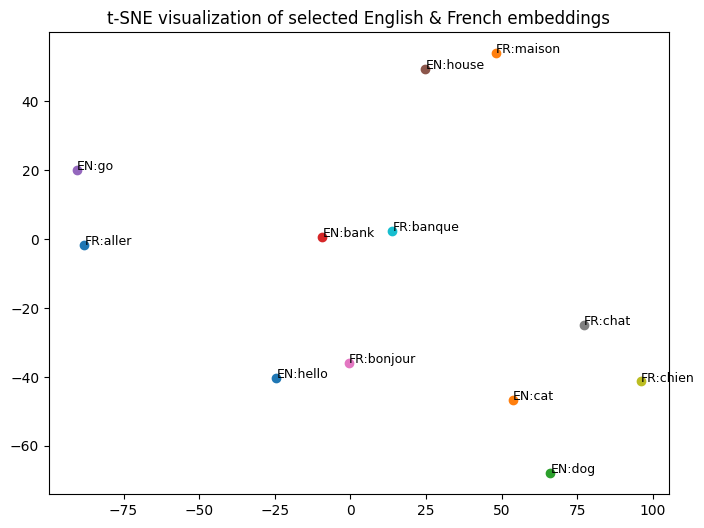

In [30]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Select some words to visualize (common words or translations)
words_en = ["hello", "cat", "dog", "bank", "go", "house"]
words_fr = ["bonjour", "chat", "chien", "banque", "aller", "maison"]

# Collect vectors
vectors = []
labels = []

for w in words_en:
    if w in w2v_en.wv.key_to_index:
        vectors.append(w2v_en.wv[w])
        labels.append("EN:" + w)

for w in words_fr:
    if w in w2v_fr_aligned:
        vectors.append(w2v_fr_aligned[w])
        labels.append("FR:" + w)

vectors = np.array(vectors)

# t-SNE reduction to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=5)
vectors_2d = tsne.fit_transform(vectors)

# Plot
plt.figure(figsize=(8,6))
for i, label in enumerate(labels):
    x, y = vectors_2d[i]
    plt.scatter(x, y)
    plt.text(x+0.01, y+0.01, label, fontsize=9)
plt.title("t-SNE visualization of selected English & French embeddings")
plt.show()

In [31]:
synonyms = [("big", "large"), ("happy", "joyful")]
antonyms = [("hot", "cold"), ("happy", "sad")]

from sklearn.metrics.pairwise import cosine_similarity

print("Synonyms similarities (EN):")
for w1, w2 in synonyms:
    sim = cosine_similarity(
        w2v_en.wv[w1].reshape(1,-1),
        w2v_en.wv[w2].reshape(1,-1)
    )[0][0]
    print(f"{w1} ↔ {w2} : {sim:.4f}")

print("\nAntonyms similarities (EN):")
for w1, w2 in antonyms:
    sim = cosine_similarity(
        w2v_en.wv[w1].reshape(1,-1),
        w2v_en.wv[w2].reshape(1,-1)
    )[0][0]
    print(f"{w1} ↔ {w2} : {sim:.4f}")

Synonyms similarities (EN):
big ↔ large : 0.6899
happy ↔ joyful : 0.2142

Antonyms similarities (EN):
hot ↔ cold : 0.7962
happy ↔ sad : 0.6472


In [32]:
pairs = [("hello", "bonjour"), ("cat", "chat"), ("house", "maison")]

for en_word, fr_word in pairs:
    sim = cosine_similarity(
        w2v_en.wv[en_word].reshape(1,-1),
        w2v_fr_aligned[fr_word].reshape(1,-1)
    )[0][0]
    print(f"{en_word} ↔ {fr_word} : {sim:.4f}")

hello ↔ bonjour : 0.5021
cat ↔ chat : 0.7562
house ↔ maison : 0.8140


In [33]:
polysemy_pairs = [("bank", "banque"), ("bank", "rive")]

for en_word, fr_word in polysemy_pairs:
    sim = cosine_similarity(
        w2v_en.wv[en_word].reshape(1,-1),
        w2v_fr_aligned[fr_word].reshape(1,-1)
    )[0][0]
    print(f"{en_word} ↔ {fr_word} : {sim:.4f}")

bank ↔ banque : 0.6858
bank ↔ rive : 0.4209


In [34]:
# English OOV
try:
    vec = w2v_en.wv["helloooo"]
except KeyError:
    print("Word2Vec cannot handle OOV 'helloooo'")

# FastText can handle it
vec_ft = ft_en.wv["helloooo"]
print("FastText vector for 'helloooo' computed successfully")

Word2Vec cannot handle OOV 'helloooo'
FastText vector for 'helloooo' computed successfully


**Classifier**

In [35]:
# Create a new dataframe containing only the English sentences
df_en = df[["en"]].copy()
# Assign label 0 to English sentences
df_en["label"] = 0
df_en = df_en[["en", "label"]]   # keep only 2 columns

# Create a new dataframe containing only the French sentences
df_fr = df[["fr"]].copy()
# Assign label 1 to French sentences
df_fr["label"] = 1
df_fr = df_fr[["fr", "label"]]

In [36]:
df_fr.head()

,fr,label
0,Essayons quelque chose !,1
1,Tentons quelque chose !,1
2,Je dois aller dormir.,1
3,Aujourd'hui nous sommes le 18 juin et c'est l'...,1
4,"Aujourd'hui c'est le 18 juin, et c'est l'anniv...",1


In [37]:
#concatenate both dfs
df_all = pd.concat([df_en, df_fr], ignore_index=True)

# create one sentence column
df_all["sentence"] = df_all["en"].fillna(df_all["fr"])

# keep only what we need
df_all = df_all[["sentence", "label"]]

df_all.head()

,sentence,label
0,Let's try something.,0
1,Let's try something.,0
2,I have to go to sleep.,0
3,Today is June 18th and it is Muiriel's birthday!,0
4,Today is June 18th and it is Muiriel's birthday!,0


In [38]:
# CONVERTING SENTENCES TO VECTORS
def sentence_vector(sentence, model):
    words = sentence.split()
    vectors = [model.wv[w] for w in words if w in model.wv.key_to_index]

    # If no word exists in the vocabulary (OOV case),
    # return a zero vector of the correct dimension
    if len(vectors) == 0:
        return np.zeros(model.vector_size)

    # Compute the mean of all word vectors
    return np.mean(vectors, axis=0)

In [40]:
#build feature matrix
X = []
y = []

for _, row in df_all.iterrows():
    vec_en = sentence_vector(row["sentence"], w2v_en)  # English embedding
    vec_fr = sentence_vector(row["sentence"], w2v_fr)  # French embedding

    # Concatenate both
    vec = np.concatenate([vec_en, vec_fr])

    X.append(vec)
    y.append(row["label"])

X = np.array(X)
y = np.array(y)

print("Feature shape:", X.shape)

Feature shape: (858744, 200)


In [41]:
#train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=True
)

In [42]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [43]:
#evaluation
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.96      1.00      0.98     85723
           1       1.00      0.96      0.98     86026

    accuracy                           0.98    171749
   macro avg       0.98      0.98      0.98    171749
weighted avg       0.98      0.98      0.98    171749



In [49]:
#give the classifier an input to test it
def detect_language(sentence):
    vec_en = sentence_vector(sentence, ft_en)
    vec_fr = sentence_vector(sentence, ft_fr)
    vec = np.concatenate([vec_en, vec_fr]).reshape(1, -1)

    pred = clf.predict(vec)[0]
    return "English" if pred == 0 else "French"

# Examples
print(detect_language("I am an Artificial Intelligence student"))
print(detect_language("je suis une etudiante"))
print(detect_language("helloooo"))  # OOV test

English
French
English
